In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from tensorflow.keras.applications import MobileNet

from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
# Define directories
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'
val_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/val'

In [3]:
image_size = (224, 224, 3)
batch_size=32

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)
val_images, val_labels = load_images(val_dir)


In [6]:
print(train_labels)
# print((train_images[0][0]))

[ 0  0  0 ... 24 24 24]


In [7]:
# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

In [8]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_datagen.fit(train_images)


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=image_size)
for layer in base_model.layers[:-5]:  # Fine-tune top 5 layers
    layer.trainable = False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
predictions = Dense(25, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,  # Adjust as needed
    validation_data=(val_images, val_labels),  # If using a validation set
    callbacks=[early_stopping]
)


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 8,559,885 (32.65 MB)

 Trainable params: 2,127,897 (8.12 MB)

 Non-trainable params: 2,176,192 (8.30 MB)

 Optimizer params: 4,255,796 (16.23 MB)

In [113]:
# Train the model (adjust epochs and batch size as needed)
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/10
234/234 [==============================] - 24s 99ms/step - loss: 0.5403 - accuracy: 0.8677 - val_loss: 0.1695 - val_accuracy: 0.9458
Epoch 2/10
234/234 [==============================] - 22s 92ms/step - loss: 0.1333 - accuracy: 0.9594 - val_loss: 0.0991 - val_accuracy: 0.9577
Epoch 3/10
234/234 [==============================] - 22s 92ms/step - loss: 0.0891 - accuracy: 0.9739 - val_loss: 0.0769 - val_accuracy: 0.9729
Epoch 4/10
234/234 [==============================] - 22s 93ms/step - loss: 0.0660 - accuracy: 0.9842 - val_loss: 0.0578 - val_accuracy: 0.9827
Epoch 5/10
234/234 [==============================] - 22s 93ms/step - loss: 0.0547 - accuracy: 0.9859 - val_loss: 0.0483 - val_accuracy: 0.9892
Epoch 6/10
234/234 [==============================] - 21s 91ms/step - loss: 0.0450 - accuracy: 0.9898 - val_loss: 0.0480 - val_accuracy: 0.9859
Epoch 7/10
234/234 [==============================] - 21s 89ms/step - loss: 0.0397 - accuracy: 0.9899 - val_loss: 0.0403 - val_accuracy:

In [14]:
# Extract features using MobileNetV1
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [115]:
# tf.keras.backend.clear_session()

In [15]:
# Extract features using the model without the top layer in batches
# Get the penultimate layer's output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


batch_size=32
# Use the extract_features function to process images in batches
train_features = extract_features(feature_extractor, train_images, batch_size)
test_features = extract_features(feature_extractor, test_images, batch_size)

print("Shape of extracted train features:", train_features.shape)
print("Shape of extracted test features:", test_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [117]:
# Extract features using the model without the top layer
# train_features = mobilenet_with_gap.predict(train_images)
# test_features = mobilenet_with_gap.predict(test_images)

In [16]:
print(train_features.shape)
print(test_features.shape)

(7459, 1024)
(957, 1024)


In [17]:
# Define the parameter grid for Decision Tree
# dt_param_grid = {'criterion': ['entropy'], 'max_depth': [ 10]}
# # n_estimators:500, max_depth:10, criterion:'entropy'
# Define the expanded parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],  # Add more depth options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Use GridSearchCV to find the best parameters for Decision Tree
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(train_features, train_labels)

# Get the best parameters for Decision Tree
best_dt_params = dt_grid_search.best_params_

# Use the best parameters to train the final Decision Tree model
final_dt_classifier = DecisionTreeClassifier(**best_dt_params)
start_time_dt = time.time()
final_dt_classifier.fit(train_features, train_labels)
train_time_dt = time.time() - start_time_dt

# Predict labels for the test set using Decision Tree
dt_predictions = final_dt_classifier.predict(test_features)

# Evaluate accuracy for Decision Tree
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print("\nBest Decision Tree Parameters:", best_dt_params)
print("Decision Tree Accuracy:", dt_accuracy)



Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.9571577847439916


In [18]:
# Additional evaluation metrics for Decision Tree
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')
recall_dt = recall_score(test_labels, dt_predictions, average='weighted')
f1_dt = f1_score(test_labels, dt_predictions, average='weighted')

print("Train Time (sec) Decision Tree:", train_time_dt)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time_dt = dt_grid_search.cv_results_['mean_fit_time'][dt_grid_search.best_index_]
print("Train Time (sec) Grid Decision Tree:", grid_train_time_dt)

# Calculate Matthews Correlation Coefficient (MCC) for Decision Tree
mcc_dt = matthews_corrcoef(test_labels, dt_predictions)
print("Matthews Correlation Coefficient (MCC) Decision Tree:", mcc_dt)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = dt_grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)

Train Time (sec) Decision Tree: 11.300041198730469
Train Time (sec) Grid Decision Tree: 9.660968701044718
Matthews Correlation Coefficient (MCC) Decision Tree: 0.9501550668807531
Optimization Algorithm Accuracy: 0.9524064152094512


In [121]:
# Confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(test_labels, dt_predictions)
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')

FP_dt = conf_matrix_dt.sum(axis=0) - np.diag(conf_matrix_dt)  
FN_dt = conf_matrix_dt.sum(axis=1) - np.diag(conf_matrix_dt)
TP_dt = np.diag(conf_matrix_dt)
TN_dt = conf_matrix_dt.sum()


In [122]:
# Display results for Decision Tree
print("\nResults for Decision Tree:")
print("Precision (Decision Tree):", precision_dt)
print("Recall (Decision Tree):", recall_dt)
print("F1 Score (Decision Tree):", f1_dt)
print("True Positive Rate (TPR) (Decision Tree):", np.mean(TP_dt / (TP_dt + FN_dt)))
print("True Negative Rate (TNR) (Decision Tree):", np.mean(TN_dt / (TN_dt + FP_dt)))
print("False Positive Rate (FPR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TN_dt)))
print("False Negative Rate (FNR) (Decision Tree):", np.mean(FN_dt / (TP_dt + FN_dt)))

print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TP_dt)))
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_dt / (FN_dt + TN_dt)))

print("Matthews Correlation Coefficient (MCC) (Decision Tree):", mcc_dt)


Results for Decision Tree:
Precision (Decision Tree): 0.9513731776188784
Recall (Decision Tree): 0.9487983281086729
F1 Score (Decision Tree): 0.949635555910758
True Positive Rate (TPR) (Decision Tree): 0.8922063099857218
True Negative Rate (TNR) (Decision Tree): 0.9979676245587592
False Positive Rate (FPR) (Decision Tree): 0.002032375441240754
False Negative Rate (FNR) (Decision Tree): 0.10779369001427826
False Discovery Rate (FDR) (Decision Tree): 0.10677937646479846
False Omission Rate (FOR) (Decision Tree): 0.002034942088796145
Matthews Correlation Coefficient (MCC) (Decision Tree): 0.9404027531552093


In [123]:
conf_matrix_dt


array([[  7,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  42,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  19,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  16,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,  13,   1,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0,   0],
       [  1,   0,   0,   0,   0,   1,  10,   1,   0,   0,   0,   0,   2,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
      

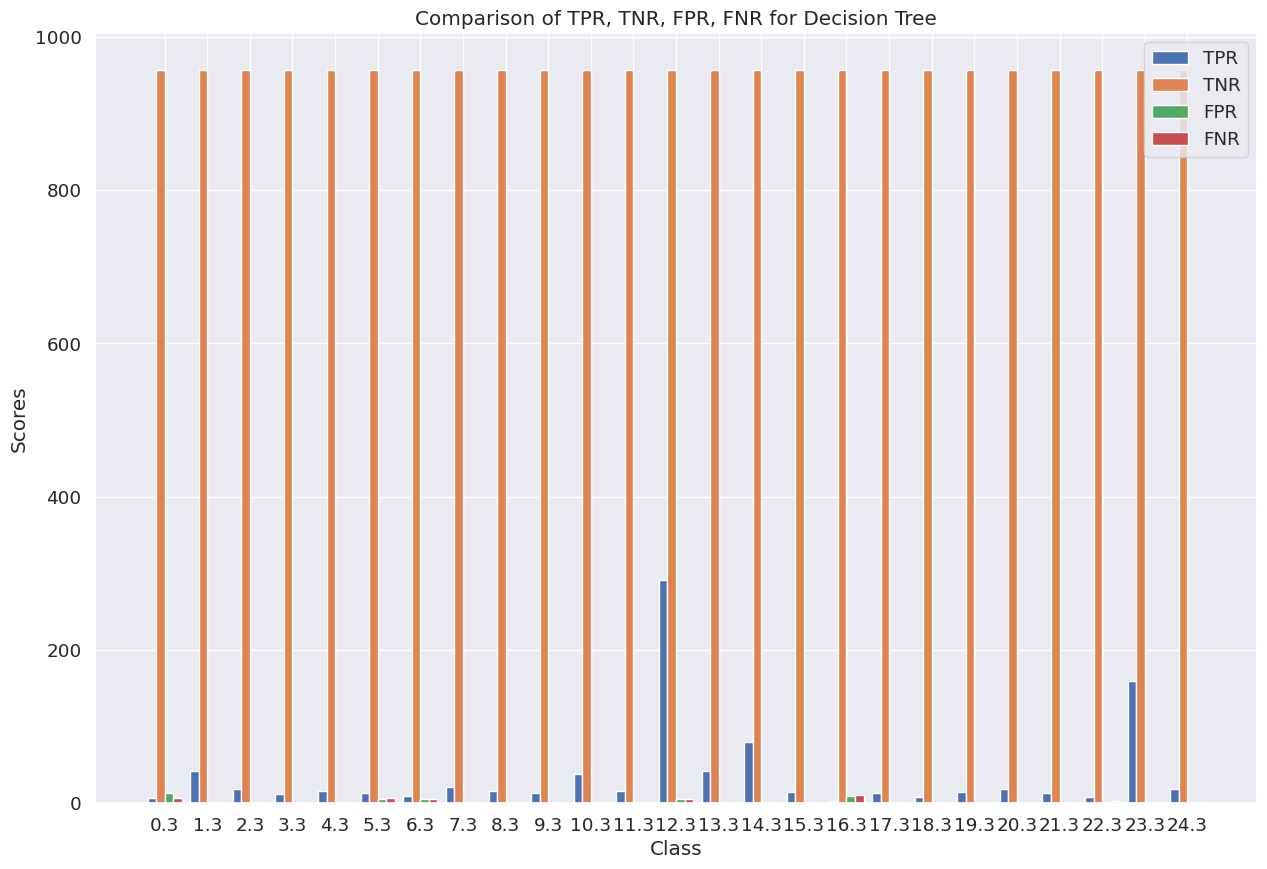

In [124]:
# Plot TPR, TNR, FPR, FNR for Decision Tree
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data



bar1 = ax.bar(index, TP_dt, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_dt, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_dt, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_dt, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Decision Tree')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

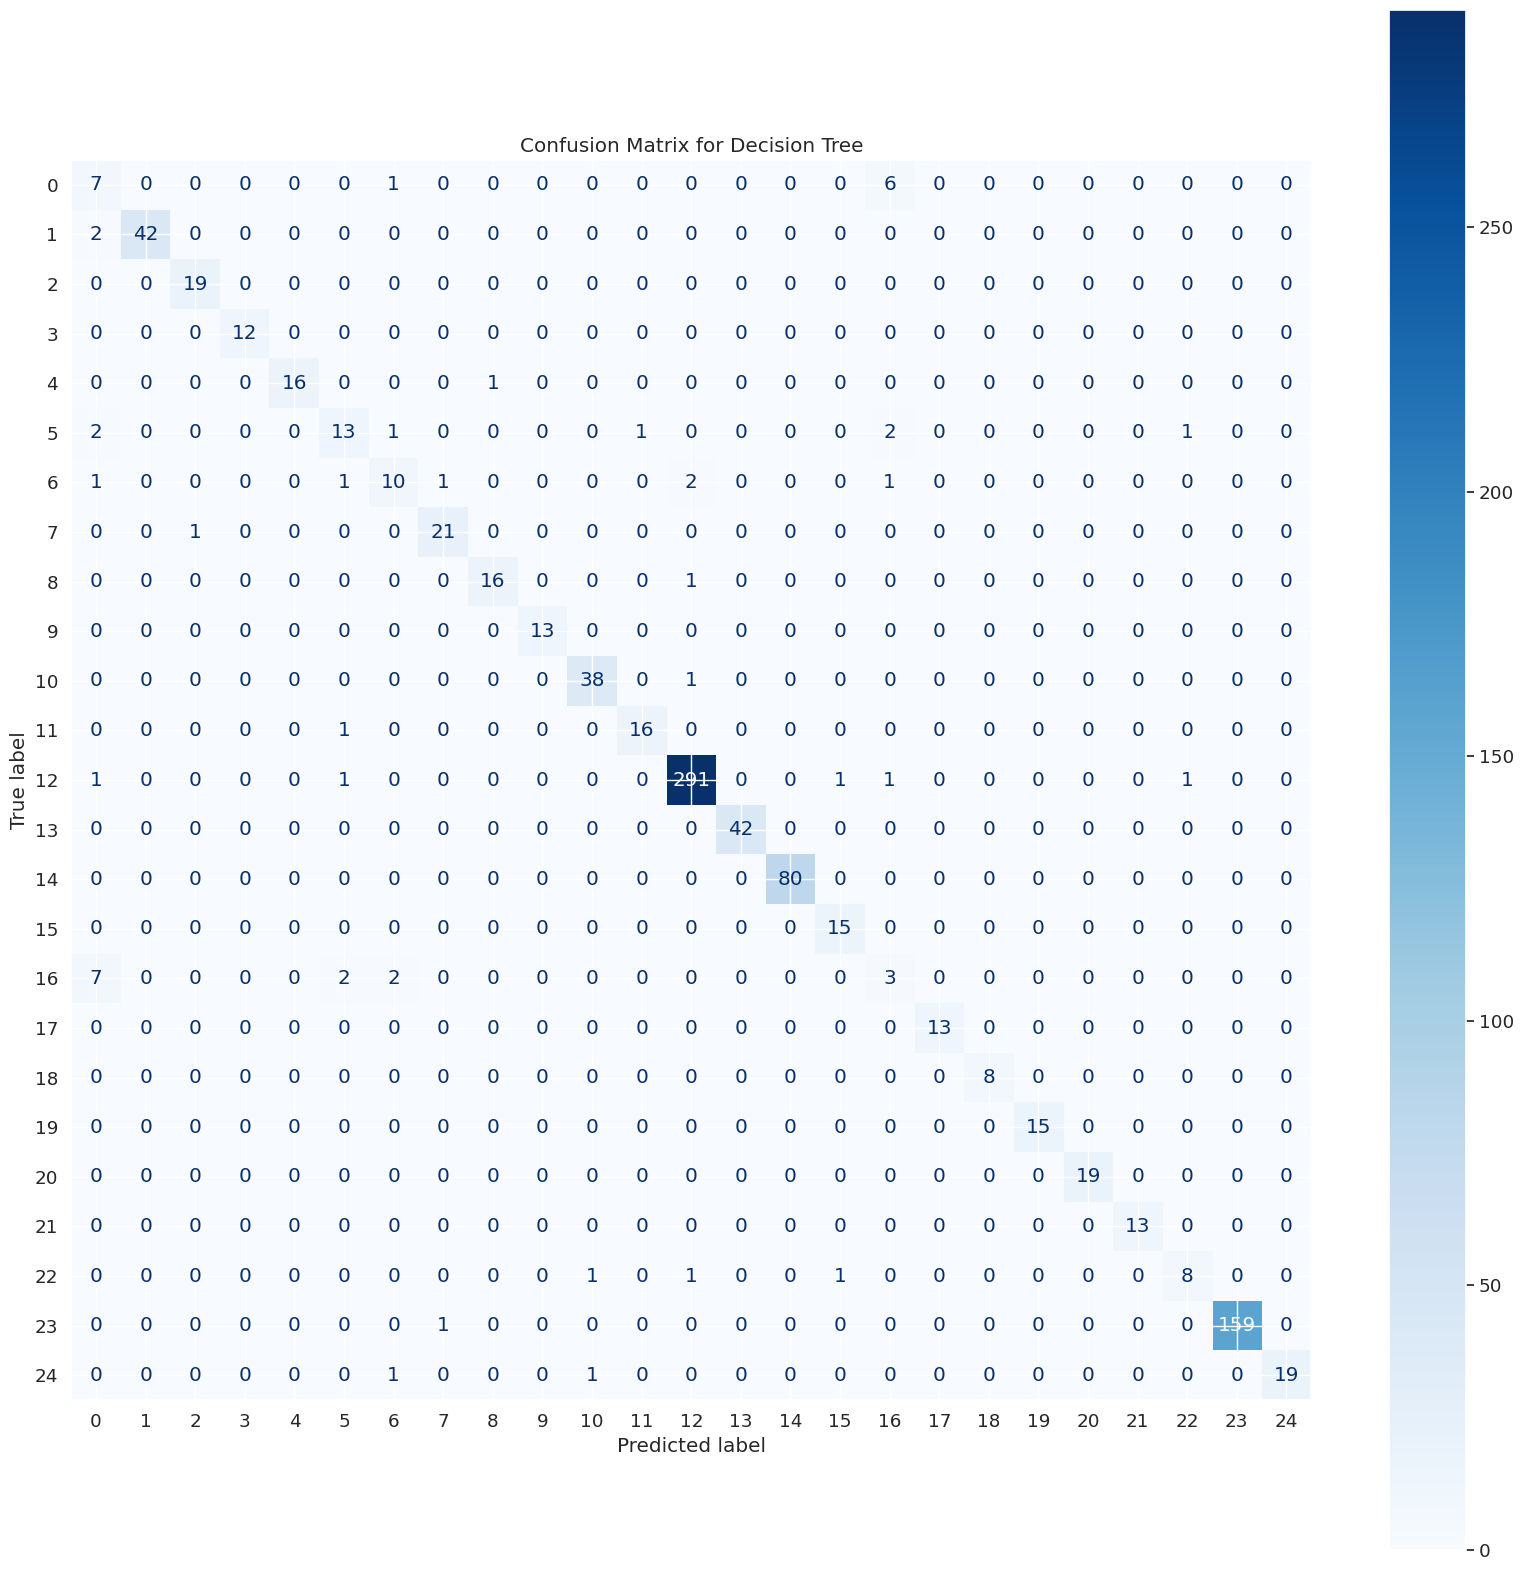

In [125]:
# Plot Confusion Matrix for Decision Tree
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_dt, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Decision Tree')
plt.show()